# **THESIS NOTES ON UWB LOCALIZATION**
By Dhonan Nabil Hibatullah

## **1. Newton-Raphson**

The UWB localization is a localization technique with anchor-tag scenario, in which there exists $n$ position-fixed anchors $(n>2)$ and $m$ moving tags. Let $a_1$, $a_2$, $...$, $a_n$; $a_i \in \mathbb{R}^2$ be the position of the anchors and $p \in \mathbb{R}^2$ be the position of the tag. Each anchor produces $r_i \in \mathbb{R}$, i.e. the received tag distance from the corresponding anchor. To model this scenario, we start with $n$ circles where each represented by:

$$C_i : \left( x_p - x_i \right)^2 + \left( y_p - y_i \right)^2 = \left(r_i-e_i\right)^2$$

$e_i$ denotes the error caused by the systems. The goal is to find:

$$\argmin_{x_p,y_p} \sum_{i \leq n}e_i^2$$

such that $p$ satisfies all $C_i$ (this may happen because $r_i$ contains error). By rearranging the expression of $C_i$:

$$e_i = r_i - \sqrt{\left( x_p - x_i \right)^2 + \left( y_p - y_i \right)^2}$$

we obtain the objective function as follows.

$$f(x_p, y_p) = \sum_{i \leq n}\left[r_i - \sqrt{\left( x_p - x_i \right)^2 + \left( y_p - y_i \right)^2}\right]^2$$

Minimize the objective function by letting $\nabla f = 0$ using Newton-Raphson.

$$\nabla f(x_p, y_p) = \begin{bmatrix}
-nx_p + \sum_{i \leq n}\left(\frac{r_i(x_p - x_i)}{\sqrt{\left( x_p - x_i \right)^2 + \left( y_p - y_i \right)^2}} + x_i\right) \\
-ny_p + \sum_{i \leq n}\left(\frac{r_i(y_p - y_i)}{\sqrt{\left( x_p - x_i \right)^2 + \left( y_p - y_i \right)^2}} + y_i\right)
\end{bmatrix} = 0$$

$$J(x_p, y_p) = \begin{bmatrix}

-n + \sum_{i \leq n}\left( \frac{r_i}{\sqrt{\left( x_p - x_i \right)^2 + \left( y_p - y_i \right)^2}} - \frac{r_i(x_p - x_i)^2}{\left(\left( x_p - x_i \right)^2 + \left( y_p - y_i \right)^2\right)^\frac{3}{2}} \right) &&

-\sum_{i \leq n}\left( \frac{r_i(x_p - x_i)(y_p-y_i)}{\left(\left( x_p - x_i \right)^2 + \left( y_p - y_i \right)^2\right)^{\frac{3}{2}}} \right) \\

-\sum_{i \leq n}\left( \frac{r_i(x_p - x_i)(y_p-y_i)}{\left(\left( x_p - x_i \right)^2 + \left( y_p - y_i \right)^2\right)^{\frac{3}{2}}} \right) &&

-n + \sum_{i \leq n}\left( \frac{r_i}{\sqrt{\left( x_p - x_i \right)^2 + \left( y_p - y_i \right)^2}} - \frac{r_i(y_p - y_i)^2}{\left(\left( x_p - x_i \right)^2 + \left( y_p - y_i \right)^2\right)^\frac{3}{2}} \right)

\end{bmatrix}$$

Iterate with:

$$p_{(k + 1)} = p_{(k)} - J^{-1}_{(k)}\nabla f_{(k)}$$

The following script shows the demonstration.

----[ TAG_0 ]----
actual position: 
(3.6, 7.1)
estimated position: 
(3.5814121968673525, 7.150206926247844)

----[ TAG_1 ]----
actual position: 
(2.0, 1.2)
estimated position: 
(2.032530555895359, 1.085787621341075)

----[ TAG_2 ]----
actual position: 
(7.1, 2.9)
estimated position: 
(7.132110018444968, 2.8478237712801353)

----[ TAG_3 ]----
actual position: 
(0.3, 2.2)
estimated position: 
(0.2381261006877779, 2.1607170080969826)



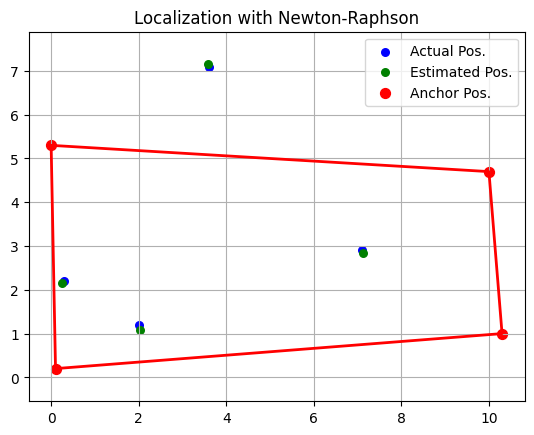

In [189]:
import numpy as np
import matplotlib.pyplot as plt



# ----[ ENVIRONMENT SETUP ]----
ANCHOR_POSITIONS = [
    (0.1, 0.2),
    (10.3, 1.0),
    (10, 4.7),
    (0.0, 5.3)
]
TAG_POSITIONS = [
    (3.6, 7.1),
    (2.0, 1.2),
    (7.1, 2.9),
    (0.3, 2.2)
]
ANCHOR_NUMBER   = len(ANCHOR_POSITIONS)
TAG_NUMBER      = len(TAG_POSITIONS)
ERROR_MAGNITUDE = 0.1
NR_ITERATION    = 10



# ----[ INITIATE THE PROBLEM ]----
anchors     = ANCHOR_POSITIONS
anchor_num  = ANCHOR_NUMBER
tags        = TAG_POSITIONS
tag_num     = TAG_NUMBER
err_mag     = ERROR_MAGNITUDE



# ----[ SOLVE THE PROBLEM ]----
# [0] Determine the position reading of tags from every anchors
readings = []
for i in range(tag_num):
    tag_reading = []
    
    for j in range(anchor_num):
        err = (2.0*np.random.rand() - 1.0)*err_mag
        tag_reading.append(
            np.sqrt((anchors[j][0] - tags[i][0])**2.0 + (anchors[j][1] - tags[i][1])**2.0) + err
        )

    readings.append(tag_reading)



# [1] Calculate the mean point of the anchors' position
mean_x = 0.0
mean_y = 0.0

for anchor in anchors:
    mean_x += anchor[0]
    mean_y += anchor[1]

mean_x /= anchor_num
mean_y /= anchor_num




# [2] Set the mean point as the initial guess of tags' position
est_tags = []
for tag in tags:
    est_tags.append(
        np.array([
            [mean_x],
            [mean_y]
        ])
    )



# [3] Calculate the nabla and jacobian
def nablaF(est_pos:np.ndarray, reading:list) -> np.ndarray:
    xp = est_pos[0].item()
    yp = est_pos[1].item()

    sumterm_x = 0.
    sumterm_y = 0.
    for i in range(anchor_num):
        dist = np.sqrt((xp - anchors[i][0])**2.0 + (yp - anchors[i][1])**2.0)
        sumterm_x += anchors[i][0] + reading[i]*(xp - anchors[i][0])/dist
        sumterm_y += anchors[i][1] + reading[i]*(yp - anchors[i][1])/dist

    return np.array([
        [sumterm_x - float(anchor_num)*xp],
        [sumterm_y - float(anchor_num)*yp]
    ])


def jacobianF(est_pos:np.ndarray, reading:list) -> np.ndarray:
    xp = est_pos[0].item()
    yp = est_pos[1].item()

    sumterm_x   = 0.
    sumterm_y   = 0.
    sumterm_xy  = 0.
    for i in range(anchor_num):
        dist    = np.sqrt((xp - anchors[i][0])**2.0 + (yp - anchors[i][1])**2.0)
        dist32  = dist*((xp - anchors[i][0])**2.0 + (yp - anchors[i][1])**2.0)
        sumterm_x   += reading[i]/dist - reading[i]*((xp - anchors[i][0])**2.0)/dist32
        sumterm_y   += reading[i]/dist - reading[i]*((yp - anchors[i][1])**2.0)/dist32
        sumterm_xy  += (reading[i]*(xp - anchors[i][0])*(yp - anchors[i][1]))/dist32
    
    return np.array([
        [sumterm_x - float(anchor_num), -sumterm_xy],
        [-sumterm_xy, sumterm_y - float(anchor_num)]
    ])


def updatePos(est_pos:np.ndarray, reading:float) -> np.ndarray:
    return est_pos - np.linalg.inv(jacobianF(est_pos, reading))@nablaF(est_pos, reading)



# [4] Compute the positions
for i in range(tag_num):
    for j in range(NR_ITERATION):
        est_tags[i] = updatePos(est_tags[i], readings[i])



# [5] Display the output
for i in range(tag_num):
    print(f'----[ TAG_{i} ]----')
    print(f'actual position: \n{tags[i]}')
    print(f'estimated position: \n{tuple(est_tags[i].T[0])}')
    print()

    plt.scatter(
        tags[i][0], 
        tags[i][1], 
        c='b', 
        s=30, 
        label='Actual Pos.' if i == 0 else ''
    )
    plt.scatter(
        est_tags[i][0], 
        est_tags[i][1], 
        c='g', 
        s=30, 
        label='Estimated Pos.' if i == 0 else ''
    )

for i in range(anchor_num):
    plt.scatter(
        anchors[i][0], 
        anchors[i][1], 
        c='r', 
        s=50, 
        label='Anchor Pos.' if i == 0 else ''
    )

plt.plot(
    [anchors[i][0] for i in range(anchor_num)] + [anchors[0][0]],
    [anchors[i][1] for i in range(anchor_num)] + [anchors[0][1]],
    lw=2,
    c='r'
)

plt.title('Localization with Newton-Raphson')
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()

After trying for some time, we might notice that some estimated tag position is just too far away from the actual position. This is because the Newton-Raphson does not always converge to the right value. Thus, we need to modify the solution to avoid this unpredictable phenomenon.

## **2. The Cramér–Rao Bound**

Suppose the tag position $p \in \mathbb{R}^2$ is an unknown deterministic parameter that is to be estimated from $n$ independent observations of $r_i, i=1, 2, ..., n$. Each from a distribution according to some Probability Density Function (PDF) $f(x | \theta)$. The Cramér–Rao bound (CRB) states the variance of any unbiased estimator $\hat{p}$ of $p$ is then bounded by the reciprocal (inverse) of the Fisher Information $I(\theta)$:

$$\text{var}\left(\hat{p}\right) \geq I^{-1}(p)$$

Fisher Information is defined as the variance of the score. Let us see the defintion of each statistical terms related to this topic.